# First steps of components Map-Making

In this notebook, we will learn how to make the component Map-Making simple. The idea is not longer fit the frequency observations but direclty the components at a reference frequency $\nu_0$. To do that, we will use module from FG-Buster code especially to define the mixing matrix $A$. Here is all the packages used during this process.

In [1]:
from __future__ import division

# QUBIC packages
import qubic
from qubicpack.utilities import Qubic_DataDir
from qubic.data import PATH
from qubic.io import read_map
import Acquisition as Acq

# General packages
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pysm3
import warnings
import pysm3.units as u
from importlib import reload
from pysm3 import utils
from qubic import QubicSkySim as qss

# FG-Buster packages
import component_model as c
import mixing_matrix as mm

# PyOperators packages
from pyoperators import (
    BlockColumnOperator, BlockDiagonalOperator, BlockRowOperator,
    CompositionOperator, DiagonalOperator, I, IdentityOperator,
    MPIDistributionIdentityOperator, MPI, proxy_group, ReshapeOperator,
    rule_manager, pcg, Operator, DenseOperator)
from pysimulators.interfaces.healpy import HealpixConvolutionGaussianOperator
warnings.filterwarnings("ignore")
%matplotlib inline

# %config InlineBackend.figure_format='retina'
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# QUBIC Dictionary

Here we define QUBIC stuff like the Pointing and the instrument or the pixelization of the sky. The main parameter to keep in mind here is :

+ Nf the number of sub-acquisitions

This Nf parameter is not the reconstructed bands as usually but the number of sub-acquisition to sample each components (CMB, Thermal Dust, etc...). The higher Nf is, the closer to the real instrument the simulation is but the process take many more time to converge. You can play with it to see differences between situations but here we fix it to 1 for the example. You must choose also a reasonable number of pointing like 2000 but should but increase for realistic simulations.

In [2]:
# Repository for dictionary
global_dir = '/pbs/home/m/mregnier/Libs/qubic/qubic/'#Qubic_DataDir()
print(global_dir)
dictfilename = global_dir + 'dicts/pipeline_demo.dict'

# Read dictionary chosen
d = qubic.qubicdict.qubicDict()
d.read_from_file(dictfilename)

from qubic import SpectroImLib as sp
from importlib import reload

Nf = 1
relative_bandwidth = 0.25
Nbfreq, nus_edge150, nus150, deltas, Delta, Nbbands = qubic.compute_freq(150, Nfreq=Nf)
Nbfreq, nus_edge220, nus220, deltas, Delta, Nbbands = qubic.compute_freq(220, Nfreq=Nf)
center = qubic.equ2gal(0, -57)
def give_dictionary(dictfilename, Nf, nside, pointing, band):
    d = qubic.qubicdict.qubicDict()
    d.read_from_file(dictfilename)
    d['nf_recon'] = Nf
    d['nf_sub'] = 1*Nf
    d['nside'] = nside
    npix=12*d['nside']**2
    d['RA_center'] = 0
    d['DEC_center'] = -57
    center = qubic.equ2gal(d['RA_center'], d['DEC_center'])
    d['effective_duration'] = 3
    #d['dtheta'] = 15
    d['npointings'] = pointing
    d['filter_nu'] = int(band*1e9)
    d['photon_noise'] = False
    d['config'] = 'FI'
    d['MultiBand'] = True
    
    return d

nside=256
pointing=1000

d150 = give_dictionary(dictfilename, Nf, nside, pointing, 150)
d220 = give_dictionary(dictfilename, Nf, nside, pointing, 220)

/pbs/home/m/mregnier/Libs/qubic/qubic/


Here we simulate our "real sky", we compute clean components from PySM and we convolve them to the QUBIC resolution (We'll see in futur notebook how to consider multiple angular resolution during the process). We compute :

+ Components which will be our true sky simulated.
+ Comp_for_pcg which wll be a sky convolved by a large beam (like 1 or 2 degree) and used as initial guess for the PCG.

In [3]:
nu0 = 150
skycmb = pysm3.Sky(nside=nside, preset_strings=['c1'])
skydust = pysm3.Sky(nside=nside, preset_strings=['d0'])
C =  HealpixConvolutionGaussianOperator(fwhm=np.deg2rad(0.39))

maps_dust = np.array(skydust.get_emission(nu0 * u.GHz, None) * utils.bandpass_unit_conversion(nu0 * u.GHz, None, u.uK_CMB).T)
maps_cmb = np.array(skycmb.get_emission(nu0 * u.GHz, None) * utils.bandpass_unit_conversion(nu0 * u.GHz, None, u.uK_CMB).T)
components = np.array([C(maps_cmb.T), C(maps_dust.T)])

C =  HealpixConvolutionGaussianOperator(fwhm=np.deg2rad(0.39))
print(C, maps_cmb.shape)
comp_for_pcg = np.array([C(maps_cmb.T), C(maps_dust.T)])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


healpixconvolutiongaussian (3, 786432)


Here we define the pointing, secene and instrument instance.

In [4]:
reload(Acq)

# Pointing
p = qubic.get_pointing(d150)

# Scene
s = qubic.QubicScene(d150)

# Instrument
q150 = qubic.QubicMultibandInstrument(d150)
q220 = qubic.QubicMultibandInstrument(d220)

You asked 1000 pointings with repeat strategy so I will provide 333 pointings repeated 3 times.


Here we define from `Acquisition.py` all the QUBIC acquisition model we need. We are interesting only by those which end by `ComponentsMapMaking`. We have choice between 3 main models :

+ QubicIntegrated : QUBIC with one band (150 or 220 GHz)
+ QubicTwoBands : QUBIC which consider both bands (150 and 220 GHz)
+ QubicWideBand : An alternative version of QUBIC FI with only one focal plane

Then, we can easily generate the noise `n`, the onverse noise covariance matrix `invN`, the operator `H` and instanciate the reconstruction pipeline. Inside modesl, because we want to construct components from TOD, you should define foregrounds model in a `comp` list.

In [6]:
reload(Acq)

# QUBIC instruments
o150 = Acq.QubicIntegratedComponentsMapMaking(q150, p, s, d150, nus_edge150, comp=[c.CMB(), c.Dust(nu0=150, temp=20)])
o220 = Acq.QubicIntegratedComponentsMapMaking(q220, p, s, d220, nus_edge220, comp=[c.CMB(), c.Dust(nu0=150, temp=20)])

# QUBIC models
otwo = Acq.QubicTwoBandsComponentsMapMaking(o150, o220, s, [c.CMB(), c.Dust(nu0=150, temp=20)])
owide = Acq.QubicTwoBandsComponentsMapMaking(o150, o220, s, [c.CMB(), c.Dust(nu0=150, temp=20)])

cov = o150.get_coverage()
pixok = cov > 0


n = Acq.QubicOtherIntegratedComponentsMapMaking(otwo, [], comp=[c.CMB(), c.Dust(nu0=150, temp=20)]).get_noise()
invN = Acq.QubicOtherIntegratedComponentsMapMaking(otwo, [], comp=[c.CMB(), c.Dust(nu0=150, temp=20)]).get_invntt_operator()
Pipeline = Acq.PipelineReconstruction(otwo, [], comp=[c.CMB(), c.Dust(nu0=150, temp=20)], type='TwoBands', convolution=False)
H = Pipeline.get_operator(np.array([1.54]), False)

Info apcdhcp125.in2p3.fr: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
In acquisition.py: self.forced_sigma=None
and self.sigma is:3.323401871576773e-17
Using theoretical TES noises
diagonal case
(991008, 991008)
905387052965142904678190040481792I
In acquisition.py: self.forced_sigma=None
and self.sigma is:3.323401871576773e-17
Using theoretical TES noises
diagonal case
(991008, 991008)
905387052965142904678190040481792I
Info apcdhcp125.in2p3.fr: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
constant
Info apcdhcp125.in2p3.fr: Allocating (991008,9) elements = 136.09423828125 MiB in FSRRotation3dMatrix.__init__.
constant


Here we define the TOD with `TOD = H.c + n` and the equation `A x = b`.

In [7]:
components[:, ~pixok, :] = 0
comp_for_pcg[:, ~pixok, :] = 0
tod = H(components)+n
A = H.T * invN * H
b = H.T * invN * tod
M = Acq.get_preconditioner(np.array([cov]))

In [8]:
sol = pcg(A, b, x0=comp_for_pcg, tol=1e-4, M=M, disp=True)

   1: 0.0013896534648128425
   2: 0.001534500994621974
   3: 0.0011752021747939996
   4: 0.0008693421983518899
   5: 0.000976343360971043
   6: 0.000939770110250689
   7: 0.0008377985513323969
   8: 0.0007109365461579444
   9: 0.0006972542453902999
  10: 0.0007797617040945742
  11: 0.0008243146970729504
  12: 0.0008359442921014528
  13: 0.0006996009720724625
  14: 0.0006475704263466387
  15: 0.0006373572677603956
  16: 0.0006592312785025445
  17: 0.0006552375453919827
  18: 0.0006021067857113708
  19: 0.0005768918138436618
  20: 0.0005475350112042301
  21: 0.0005248228525939729
  22: 0.0005032493845636027
  23: 0.0004868689564617976
  24: 0.00047381586763620446
  25: 0.0004725416456884815
  26: 0.0004488125981460194
  27: 0.0006340994680715129
  28: 0.0005864604496311799
  29: 0.00041385909170749314
  30: 0.00037937119108192
  31: 0.00036406101726894837
  32: 0.00035161603067833397
  33: 0.00034029026053285417
  34: 0.0003300207020542834
  35: 0.0003240990203521588
  36: 0.000330233626

In [9]:
outputs = sol['x'].copy()
inputs = components.copy()
#inputs[:, ~pixok, :] = hp.UNSEEN

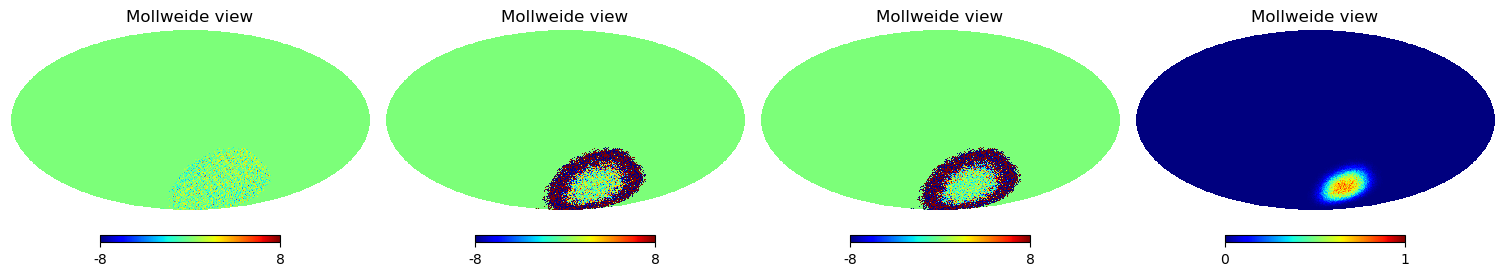

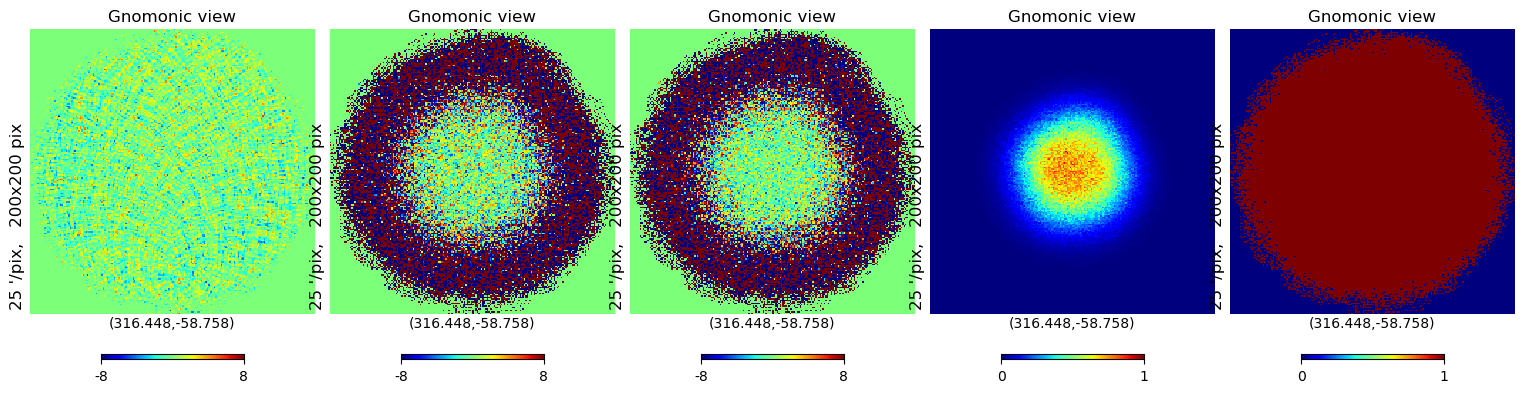

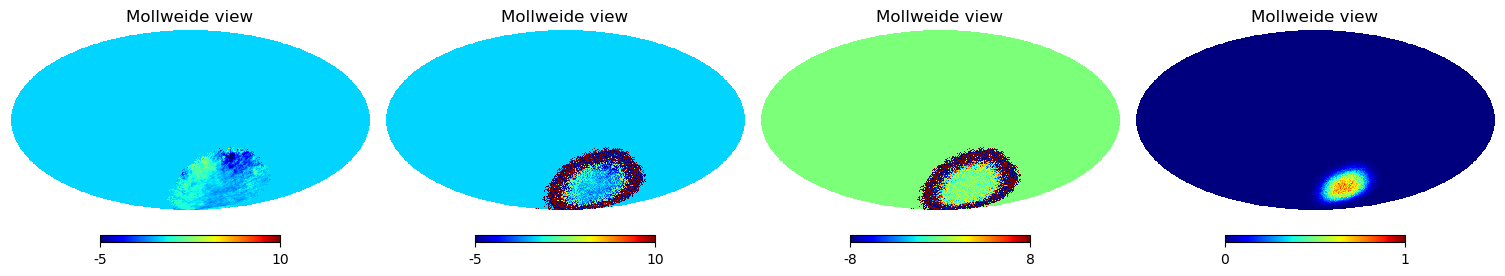

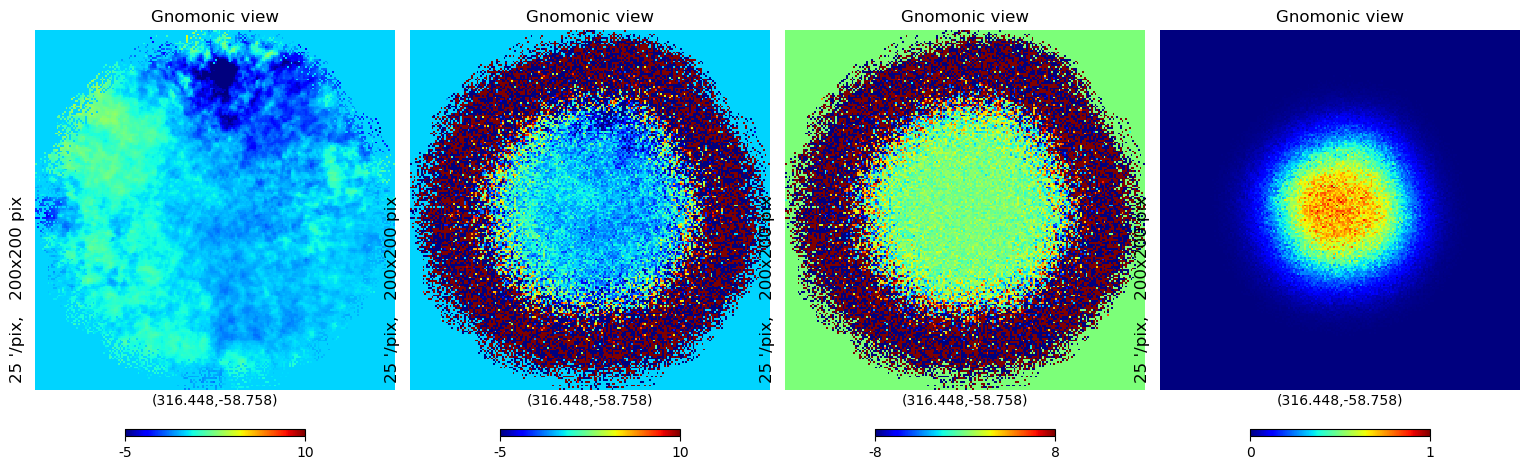

In [10]:
r = 8
rr = 8
reso= 25
istk = 2

plt.figure(figsize=(15, 5))
hp.mollview(inputs[0, :, istk], cmap='jet', min=-rr, max=rr, sub=(1, 4, 1))
hp.mollview(outputs[0, :, istk], cmap='jet', min=-rr, max=rr, sub=(1, 4, 2))
hp.mollview(inputs[0, :, istk] - outputs[0, :, istk], cmap='jet', min=-r, max=r, sub=(1, 4, 3))
hp.mollview(cov/cov.max(), cmap='jet', min=0, max=1, sub=(1, 4, 4))
plt.show()

plt.figure(figsize=(15, 5))
hp.gnomview(inputs[0, :, istk], cmap='jet', min=-rr, max=rr, sub=(1, 5, 1), rot=center, reso=reso)
hp.gnomview(outputs[0, :, istk], cmap='jet', min=-rr, max=rr, sub=(1, 5, 2), rot=center, reso=reso)
hp.gnomview(inputs[0, :, istk] - outputs[0, :, istk], cmap='jet', min=-r, max=r, sub=(1, 5, 3), rot=center, reso=reso)
hp.gnomview(cov/cov.max(), cmap='jet', min=0, max=1, sub=(1, 5, 4), rot=center, reso=reso)
hp.gnomview(pixok, cmap='jet', min=0, max=1, sub=(1, 5, 5), rot=center, reso=reso)
plt.show()


plt.figure(figsize=(15, 5))
hp.mollview(inputs[1, :, istk], cmap='jet', min=-5, max=5, sub=(1, 4, 1))
hp.mollview(outputs[1, :, istk], cmap='jet', min=-5, max=5, sub=(1, 4, 2))
hp.mollview(inputs[1, :, istk] - outputs[1, :, istk], cmap='jet', min=-r, max=r, sub=(1, 4, 3))
hp.mollview(cov/cov.max(), cmap='jet', min=0, max=1, sub=(1, 4, 4))
plt.show()

plt.figure(figsize=(15, 5))
hp.gnomview(inputs[1, :, istk], cmap='jet', min=-5, max=10, sub=(1, 4, 1), rot=center, reso=reso)
hp.gnomview(outputs[1, :, istk], cmap='jet', min=-5, max=10, sub=(1, 4, 2), rot=center, reso=reso)
hp.gnomview(inputs[1, :, istk] - outputs[1, :, istk], cmap='jet', min=-r, max=r, sub=(1, 4, 3), rot=center, reso=reso)
hp.gnomview(cov/cov.max(), cmap='jet', min=0, max=1, sub=(1, 4, 4), rot=center, reso=reso)
plt.show()